In [698]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [699]:
%%bash
data_path=/content/drive/MyDrive/vkr/
cp -r $data_path/train_data .

In [700]:
!pip install shap

In [701]:
# !pip install mapclassify
import geopandas as gpd
import folium

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz

from calendar import monthrange
import os, json, shutil

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers as rg

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import scipy.stats as st
import scipy

from statsmodels.stats.outliers_influence import variance_inflation_factor

# from sklearn.preprocessing import MinMaxScaler


In [702]:
train_files_path = "train_data/dataset_mlp/"

##### Prepare datasets

In [703]:
# read the test dataset and drop columns to correspond to the training dataset
test_ds = pd.read_csv(train_files_path + "test_dataset_2024.csv", sep=";").drop(columns=["Unnamed: 0"])
test_ds["vegetation_type"] = test_ds["vegetation_type"].astype(int)

train_ds = pd.read_csv(train_files_path + "dataset.csv", sep=";").drop(columns=["Unnamed: 0"])

Index([ 1097,  1098,  1099,  1100,  1101,  1102,  1103,  1104,  1105,  1106,
       ...
       18304, 18305, 18306, 18307, 18308, 18309, 18310, 18311, 18312, 18313],
      dtype='int64', length=10653)
(2777,)


(is_fire
 0    7876
 1    7661
 Name: count, dtype: int64,
 <Axes: >)

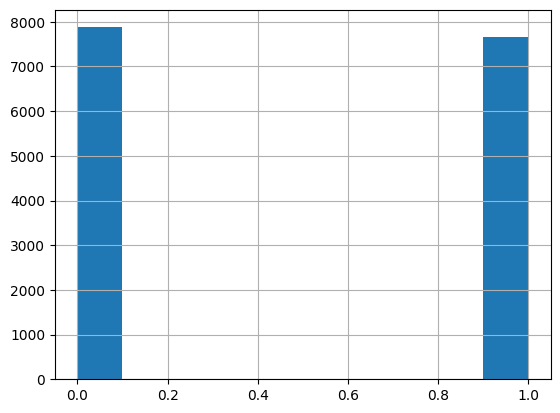

In [704]:
# drop nonfires
drop_nonfires_idx = train_ds[(train_ds.is_fire == 0)].index
assert drop_nonfires_idx.duplicated().sum() == 0
print(drop_nonfires_idx)
idx = drop_nonfires_idx.to_numpy()
np.random.shuffle(idx)
vc = train_ds.is_fire.value_counts()
a = -215
diff = vc[0] - vc[1] + a
drop_idx = idx[:diff]
print(drop_idx.shape)

train_ds = train_ds.drop(index=drop_idx)
train_ds = train_ds.reset_index(drop=True)
train_ds.is_fire.value_counts(), train_ds.is_fire.hist()

In [705]:
# exclude cols in train_ds
ex_cols = []
train_ds_ = train_ds.loc[:, ~train_ds.columns.isin(ex_cols)]

<Axes: >

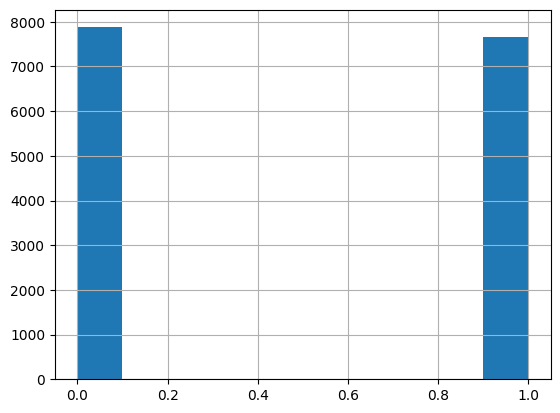

In [707]:
features = train_ds_.loc[:, ~train_ds_.columns.isin(["is_fire", "event_date"])]
target = train_ds_["is_fire"]
features = features.reset_index(drop=True)
target = target.reset_index(drop=True)
target.hist()

In [708]:
# normalize vegetation_type
vt = features.vegetation_type
transform_ = (vt - vt.mean()) / vt.std()

features_ex = features.copy()
features_ex.vegetation_type = transform_

In [709]:
# randomly permute train dataset if needed
rand_idx = np.random.permutation(len(features_ex))
print(rand_idx)
# Carefull !!! iloc, that doesn't mean that the index will correspond, check if it's the RangeIndex or not
features_ex = features_ex.iloc[rand_idx]
target = target.iloc[rand_idx]

[14138  2461 12034 ... 13151  5723    40]


<Axes: >

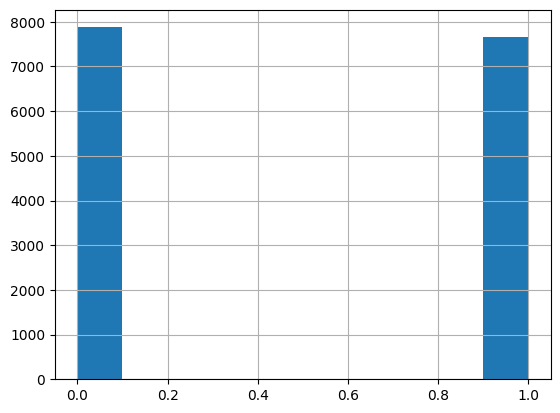

In [710]:
# X_train_ds, X_val_ds, y_train_ds, y_val_ds = train_test_split(features_ex, target, test_size=0.1, random_state=4)
X_train_ds = features_ex.copy()
y_train_ds = target.copy()
y_train_ds.hist()

Prepare the test dataset so that it corresponds to the train ds

Is the X train and X test columns order equal? True
The target name: is_fire


<Axes: >

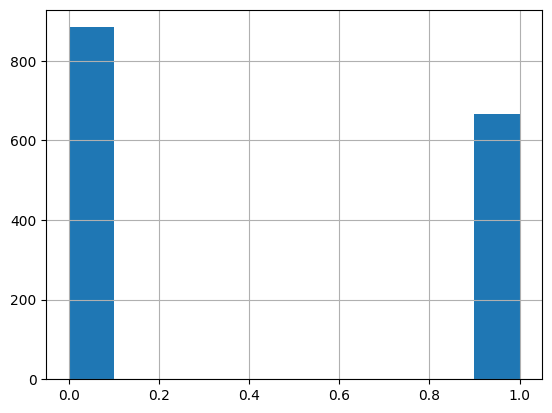

In [711]:
# prepare the test dataset

target_col = target.name
train_ds_cols = X_train_ds.columns.to_list() + [target_col]
test_ds_ = test_ds.loc[:, test_ds.columns.isin(train_ds_cols)]

X_test_ds = test_ds_.loc[:, ~test_ds_.columns.isin([target_col])]
# arrange X_test_ds so that its columns order corresponds to the X_train_ds (carefull! pd.DataFrame)
X_test_ds = X_test_ds.reindex(X_train_ds.columns, axis="columns")
# assert that no NaN columns appeared after the reindex
assert X_test_ds.isnull().sum().sum() == 0
y_test_ds = test_ds_.loc[:, target_col]
print("Is the X train and X test columns order equal?", (X_train_ds.columns == X_test_ds.columns).all(), )
print("The target name:", y_test_ds.name)
# print(X_train_ds.head(2), X_test_ds.head(2), sep="\n")

# normalize X_test using z-score (like X_train)
# print("*" * 100, "Normalizing the test dataset", sep="\n")
X_test_ds = (X_test_ds - X_test_ds.mean()) / X_test_ds.std()
y_test_ds.hist()

In [712]:
# permute the test dataset
rand_idx_test = np.random.permutation(len(X_test_ds))
X_test_ds = X_test_ds.iloc[rand_idx_test]
y_test_ds = y_test_ds.iloc[rand_idx_test]

In [713]:
X_train = X_train_ds.to_numpy()
y_train = y_train_ds.to_numpy().reshape(-1, 1)
X_test = X_test_ds.to_numpy()
y_test = y_test_ds.to_numpy().reshape(-1, 1)
print(f"Train dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Test dataset shape: {X_test.shape}, {y_test.shape}")

Train dataset shape: (15537, 13), (15537, 1)
Test dataset shape: (1550, 13), (1550, 1)


##### Build and train the model

In [724]:
input_shape = (X_train.shape[1], )
learning_rate = 0.001

model = Sequential()

model.add(Input(shape=input_shape))

model.add(Dense(units=512, activation="relu",)) 
model.add(Dense(units=128, activation="relu",)) 
model.add(Dense(units=64, activation="relu",)) 
model.add(Dense(units=8, activation="relu",))

model.add(Dense(1, activation="sigmoid"))
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy", "f1_score", tf.metrics.AUC()] #, "precision", "recall"])
)

In [725]:
model_epochs_ = 100
batch_size_ = 64
val_split_ = 0.2

callback_ = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min", start_from_epoch=3)
model_history = model.fit(
    X_train, y_train, epochs = model_epochs_,
    batch_size = batch_size_,
    validation_split = val_split_,
    callbacks = [callback_],
)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7593 - auc_23: 0.8374 - f1_score: 0.6619 - loss: 0.4949 - val_accuracy: 0.8205 - val_auc_23: 0.9030 - val_f1_score: 0.6649 - val_loss: 0.3936
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8174 - auc_23: 0.9022 - f1_score: 0.6562 - loss: 0.3927 - val_accuracy: 0.8372 - val_auc_23: 0.9142 - val_f1_score: 0.6649 - val_loss: 0.3710
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8340 - auc_23: 0.9129 - f1_score: 0.6594 - loss: 0.3708 - val_accuracy: 0.8353 - val_auc_23: 0.9115 - val_f1_score: 0.6649 - val_loss: 0.3791
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8376 - auc_23: 0.9159 - f1_score: 0.6631 - loss: 0.3634 - val_accuracy: 0.8423 - val_auc_23: 0.9181 - val_f1_score: 0.6649 - val_loss: 0.3631
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8393 - auc_23: 0.9215 - f1_score: 0.6579 - loss: 0.3516 - val_accuracy: 0.8481 - val_auc_23: 0.91

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 512)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,853 (956.46 KB)

 Trainable params: 81,617 (318.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,236 (637.64 KB)

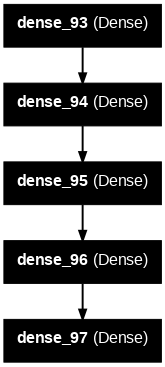

In [726]:
model.summary()
tf.keras.utils.plot_model(
    model=model, to_file="arch.png",
    # show_layer_activations=True, show_shapes=True,
    show_layer_names=True,
    dpi=70
)

Evaluate the results

In [727]:
print(model.evaluate(X_test, y_test))
model.metrics_names

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7812 - auc_23: 0.8724 - f1_score: 0.5921 - loss: 0.4663
[0.44878295063972473, 0.7987096905708313, 0.6013543605804443, 0.8817898631095886]


['loss', 'compile_metrics']

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1550, 1)
AUC score: 0.8816514478279185


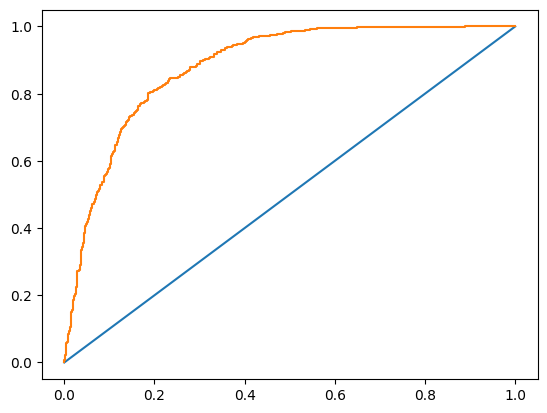

In [728]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print("AUC score:", roc_auc_score(y_test, y_pred))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)

In [729]:
import plotly.graph_objs as go

trace = go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='darkorange', width=2), text=thresh)
reference_line = go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Reference Line',
                            line=dict(color='navy', width=2, dash='dash'))
fig = go.Figure(data=[trace, reference_line])
fig.update_layout(title='Interactive ROC Curve',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate')
fig.show()

In [730]:
thresh_ = 0.5
y_pred_class = (y_pred > thresh_).astype(int)
print(y_pred_class.shape)
np.unique(y_pred_class)

(1550, 1)


array([0, 1])

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       884
           1       0.74      0.83      0.78       666

    accuracy                           0.80      1550
   macro avg       0.80      0.80      0.80      1550
weighted avg       0.81      0.80      0.80      1550



<Axes: >

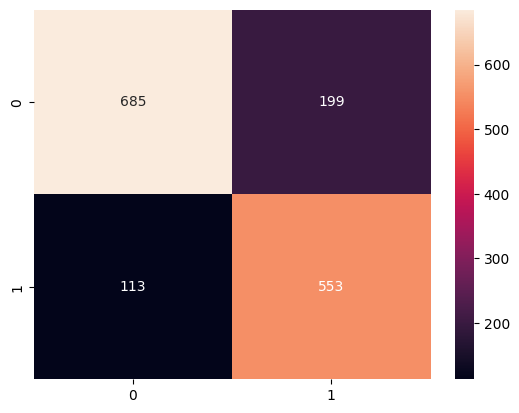

In [731]:
print(classification_report(y_true=y_test, y_pred=y_pred_class))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_class)
sns.heatmap(cm, annot=True, fmt="g")

##### Shap analysis

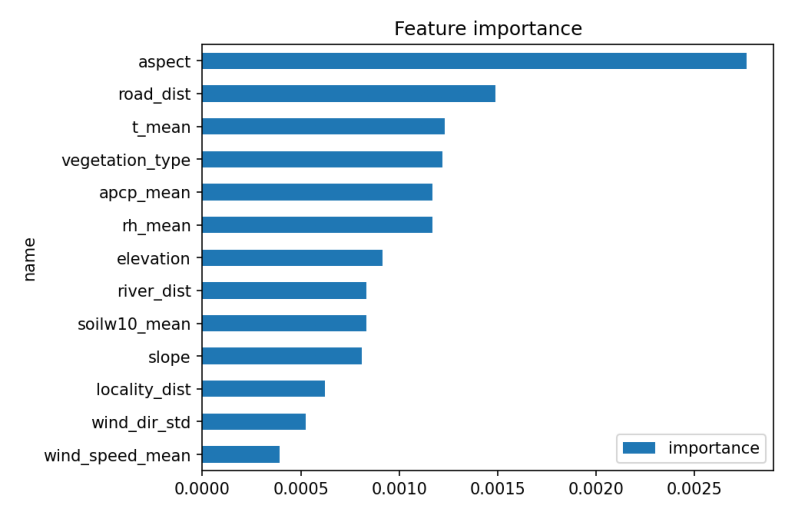

In [733]:
import shap

exp = shap.Explainer(model, X_train[1000:2000], feature_names=X_train_ds.columns)
shap_val = exp(X_test)

cols = X_train_ds.columns

# shap bar plot
shap_ds = pd.DataFrame(np.abs(shap_val).mean(0), columns=cols)
print(shap_ds)
shap_col = shap_ds.values.mean(0)
df = pd.DataFrame(list(zip(cols, shap_col)), columns=["name", "importance"])
df.sort_values(by=["importance"], inplace=True)
print("Feature importance dataset\n", df)
df.plot.barh(x="name", y="importance", stacked=False, title="Feature importance")
plt.close()